# Kalman filter strat tests

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import time
from IPython.display import clear_output

import statsmodels.formula.api as sm
import statsmodels.tsa.stattools as ts
import statsmodels.tsa.vector_ar.vecm as vm

In [2]:
df1 = pd.read_csv("../data/testing-hourly/CELRUSDT-minute.csv", index_col=0, parse_dates=True)
df2 = pd.read_csv("../data/testing-hourly/FETUSDT-minute.csv", index_col=0, parse_dates=True)

In [3]:
df = df1.open.rename("A").to_frame()
df["B"] = df2.open

In [4]:
df = df[1000:]
df = df.dropna()

## Zscore--standard

In [5]:
results = sm.ols(formula="B ~ A", data=df[['B', 'A']]).fit()
hedgeRatio = results.params[1]
print('hedgeRatio=%f' % hedgeRatio)

hedgeRatio=8.966777


In [6]:
spread = pd.Series((df['B'] - hedgeRatio * df['A'])).rename("spread").to_frame()
spread["mean"] = spread.spread.rolling(4000).mean()
spread["std"] =  spread.spread.rolling(4000).std()
spread["zscore"] = pd.Series((spread["spread"]-spread["mean"])/spread["std"])

## Zscore--constant look back period

In [36]:
np.arange(len(hedgeRatio[::60]))

array([    0,     1,     2, ..., 20191, 20192, 20193])

In [42]:
df.index[100000]

Timestamp('2019-06-03 17:20:00')

In [47]:
import math

In [49]:
lookback = 100000
ds = 60 #downsample
start = time.time()
hedgeRatio = np.full(df.shape[0], np.nan)
l = math.floor(len(hedgeRatio[:-lookback])/60)
index = []
for t in np.arange(l):
    clear_output()
    print(f"{t} < {l}")
    regress_results = sm.ols(formula="B ~ A",
                             data=df[t*ds:t*ds+lookback]).fit()  # Note this can deal with NaN in top row
    hedgeRatio[t] = regress_results.params[1]
    index.append(df.index[t*ds+lookback])
time.time()-start

18526 < 18527


693.1345770359039

<AxesSubplot:>

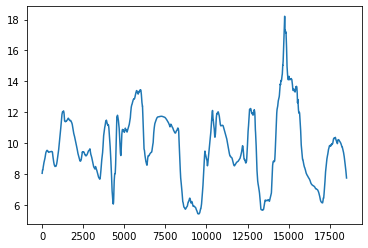

In [50]:
pd.Series(hedgeRatio).plot()

In [61]:
hedgeRatio

array([8.04847543, 8.06292645, 8.07919026, ...,        nan,        nan,
              nan])

In [75]:
hr = pd.Series(hedgeRatio).dropna().rename("hr").to_frame()
hr["index"] = index
hr.set_index("index", inplace=True)

<AxesSubplot:xlabel='index'>

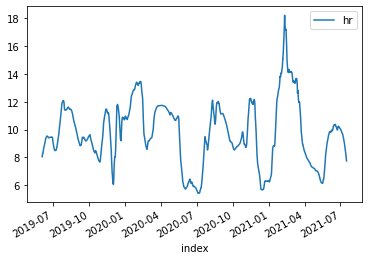

In [77]:
hr.plot()

## Kalman filter lookback period

In [78]:
x = df['A']
y = df['B']

In [79]:
x = np.array(ts.add_constant(x))[:,
    [1, 0]]

In [82]:
delta = 0.0001  # delta=1 gives fastest change in beta, 
                #delta=0.000....1 allows no change (like traditional linear regression).

In [83]:
yhat = np.full(y.shape[0], np.nan)  # measurement prediction
e = yhat.copy()
Q = yhat.copy()

In [84]:
# For clarity, we denote R(t|t) by P(t). Initialize R, P and beta.
R = np.zeros((2, 2))
P = R.copy()
beta = np.full((2, x.shape[0]), np.nan)
Vw = delta / (1 - delta) * np.eye(2)
Ve = 0.001

In [85]:
# Initialize beta(:, 1) to zero
beta[:, 0] = 0

In [87]:
# Given initial beta and R (and P)
for t in range(len(y)):
    clear_output()
    print(f"{t} < {len(y)}")
    if t > 0:
        beta[:, t] = beta[:, t - 1]
        R = P + Vw

    yhat[t] = np.dot(x[t, :], beta[:, t])
    #    print('FIRST: yhat[t]=', yhat[t])

    Q[t] = np.dot(np.dot(x[t, :], R), x[t, :].T) + Ve
    #    print('Q[t]=', Q[t])

    # Observe y(t)
    e[t] = y[t] - yhat[t]  # measurement prediction error
    #    print('e[t]=', e[t])
    #    print('SECOND: yhat[t]=', yhat[t])

    K = np.dot(R, x[t, :].T) / Q[t]  # Kalman gain
    #    print(K)

    beta[:, t] = beta[:, t] + np.dot(K, e[t])  # State update. Equation 3.11
    #    print(beta[:, t])

    # P=R-np.dot(np.dot(K, x[t, :]), R) # State covariance update. Euqation 3.12
    P = R - np.dot(np.outer(K, x[t, :]), R)  # Thanks to Matthias for chaning np.dot -> np.outer!

1211636 < 1211637


In [88]:
beta

array([[ 8.40256105,  8.78974546,  8.90830434, ...,  4.4511173 ,
         4.45145285,  4.45210737],
       [-0.02364848, -0.02384   , -0.02335267, ...,  0.103276  ,
         0.10348108,  0.10387571]])

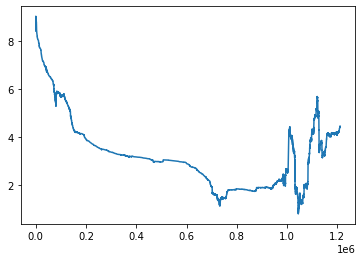

In [117]:
plt.plot(beta[0, :])
# plt.plot(beta[1, :])
# plt.plot(e[2:])
# plt.plot(np.sqrt(Q[2:]))

In [108]:
pd.Series(beta[0, :]).to_csv("../data/test.csv", index=False)

In [105]:
pd.Series(beta[0, :]).to_csv("../data/test.csv")

In [109]:
def get_a_b(al, ac, ah, bl, bc, bh):
    return ac-abs(ac-al)/2, ac+abs(ac-ah)/2, bc-abs(bc-bl)/2, bc+abs(bc-bh)/2

In [110]:
fee = 0.003       #Set double normal rate
thres = 1.        #2
sell_thres = 1.   # 0, in range [0, ...) for more travel

In [111]:
beta[1, :]

array([-0.02364848, -0.02384   , -0.02335267, ...,  0.103276  ,
        0.10348108,  0.10387571])

## Bollinger bands

In [7]:
def bbands(price, window=None, width=None, numsd=None):
    """ returns average, upper band, and lower band"""
    ave = price.rolling(window).mean()
    sd = price.rolling(window).std(ddof=0)
    if width:
        upband = ave * (1+width)
        dnband = ave * (1-width)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)        
    if numsd:
        upband = ave + (sd*numsd)
        dnband = ave - (sd*numsd)
        return price, np.round(ave,3), np.round(upband,3), np.round(dnband,3)

In [11]:
window=10000
numsd=1
df0 = pd.DataFrame()
df0['zscore'],df0['ave'],df0['upper'],df0['lower']=bbands(spread.zscore, window=window, numsd=numsd)
df0.dropna(inplace=True)
df0

,zscore,ave,upper,lower
timestamp,,,,
2019-04-04 13:58:00,0.161695,0.693,1.497,-0.110
2019-04-04 13:59:00,0.161957,0.693,1.497,-0.110
2019-04-04 14:00:00,0.119801,0.693,1.497,-0.110
2019-04-04 14:01:00,0.035208,0.693,1.497,-0.110
2019-04-04 14:02:00,0.037957,0.693,1.497,-0.110
...,...,...,...,...
2021-07-16 12:52:00,-0.209029,-0.230,0.972,-1.433
2021-07-16 12:53:00,-0.299582,-0.230,0.972,-1.433
2021-07-16 12:54:00,-0.454894,-0.231,0.972,-1.433


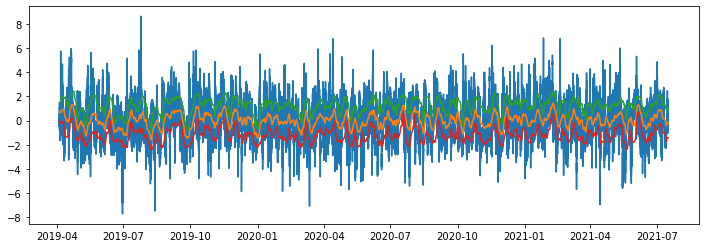

In [12]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df0);